# Infection rate vs positive opinion fraction for different system size

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

plt.style.use("../config/custom_plots.mplstyle")

```yaml
nAgents: 10000
nSteps: 100
nSaveSteps: 1
nRuns: 5
networkP: 0.8
networkM: 10
additionalLinksFraction: 0.01
virtualLayer: true
epidemicLayer: true
comorbidities: false
qVoterParameters:
  p: 0.2
  q: 6
epidemicLayerParameters:
  beta: 0.1
  zeta: 0.0
  alpha: 0.0
  gamma: 0.5
  mu: 0.9
  kappa: 0.1
maxInfectedTimeMean: 10
maxInfectedTimeStd: 5
positiveOpinionFraction: 0.9
proPisFraction: 0.0
pisVaccinationCorrelation: 0.0
infectedFraction: 0.1
fractionIllnessA: 0.0
fractionIllnessB: 0.0
outputFolder: simulations/fig1_2_infection_rate_vs_posFrac
firstParameterRange:
  start: 0.0
  end: 0.5
  count: 0
  vals: [0.01, 0.05, 0.1, 0.5]
  type: beta
secondParameterRange:
  start: 0.0
  end: 1.0
  count: 21
  vals: null
  type: positiveOpinionFraction
thirdParameterRange: null
  # start: 0
  # end: 0
  # count: 0
  # vals: [0.01, 0.05, 0.1, 0.3, 0.5]
  # type: p
linksRemoval: false
nQVoterPerStep: 1
vaccinationFraction: 0.0
neglectNeighboursPiS: false
```

In [15]:
def load_df(prefix, beta, folder, p, fracPos, nagents=10000, q=6, qvotersteps=1, nsteps=100, nruns=10):
    dfs = []
    for n in range(nruns):
        path = f"../simulations/{folder}/{prefix}_NAGENTS={nagents}_NSTEPS={nsteps}_NETWORKP=0.8_FRAC_LINKS=0.01_FRAC_POS_OPINION={fracPos}_FRAC_INFECTED=0.1_QVOTER=p={p}_q={q}_PIS=0.0_EPIDEMIC=beta={beta}_zeta=0,00_alpha=0,00_gamma=0,50_mu=0,90_kappa=0,10_QVOTERSTEPS={qvotersteps}_NRUN={n}.tsv"
        path = path.replace(',', '.')
        df = pd.read_csv(path, sep="\t")
        dfs.append(df)
    dfs1 = pd.DataFrame(np.array([x.to_numpy() for x in dfs]).mean(axis=0),
                        index=df.index, 
                        columns=df.columns)
    columns = [f'{s}Std' for s in df.columns]
    dfs1Std = pd.DataFrame(np.array([x.to_numpy() for x in dfs]).std(axis=0),
                        index=df.index, 
                        columns=columns)
    dfs1Std['step'] = dfs1['step']
    dfs1 = dfs1.merge(dfs1Std, on='step')

    return dfs1


betas = ['0,01', '0,05', '0,10', '0,50']
# betas_float = [float(b.replace(',', '.')) for b in betas]

ps = ['0,01', '0,05', '0,10', '0,30', '0,50']
ps = [p.replace(',', '.') for p in ps]

fPs = [x / 100 for x in range(101)][::5]

print('ps: ', ps)
print('Betas: ', betas, len(betas))
print('pos opnion fracs: ', fPs, len(fPs))

ps:  ['0.01', '0.05', '0.10', '0.30', '0.50']
Betas:  ['0,01', '0,05', '0,10', '0,50'] 4
pos opnion fracs:  [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0] 21


In [18]:
def load_dfs(beta, ps=ps, fPs=fPs, path='fig1_2_infection_rate_vs_posFrac_nruns_10', prefix='off'):
    """
    { p: list of dataframes, one per `positiveOpinionFraction` value }
    
    e.g.

    {p: [pd.DataFrame(beta=0.00), pd.DataFrame(beta=0.01), ...]}
    """
    xs = {}
    for p in tqdm(ps):
        xs_per_p = []
        for posFrac in fPs:
            df1 = load_df(prefix, beta, path, p, posFrac)
            xs_per_p.append(df1)
        xs[p] = xs_per_p
    return xs


def load_all_dfs(betas):
    """
    { qvoterstep: {beta: list of dataframes}, ... }
    """
    df_per_p = {}
    for beta in betas:
        df_per_p[beta] = load_dfs(beta)
    return df_per_p 

In [19]:
%%time


dfs_betas = load_all_dfs(betas)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 32.1 s, sys: 158 ms, total: 32.2 s
Wall time: 32.2 s


In [48]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


colors = ['golden yellow', 'soft purple', 'red', 'true blue', 'grass']
# colors = ['red', 'green', 'blue', 'purple', 'brown']
colors = ['xkcd:' + c for c in colors]
markers = ['o', 'v', '^', 'D', 's']

def max_infection_rate(df):
    return df['infectedRate'].max()

def max_infection_rate_std(df, fun):
    return df['infectedRateStd'][df['infectedRate'] == fun(df)].values[0]

def max_quarantine_rate(df):
    return df['quarantinedRate'].max()

def last_opinion(df):
    return df['meanOpinion'].to_numpy()[-1]

def last_recovered_rate(df):
    return df['recoveredRate'].to_numpy()[-1]

def time_max_infection(df):
    return df[df['infectedRate'] == df['infectedRate'].max()].step.to_numpy()[0]


def plot_max_infection_peak_vs_beta_per_posFrac(dfs, fPs=fPs, markers=markers, colors=colors,
                                                fun=max_infection_rate, add_legend=False):
    i = 0
    markers_legend = []
    for p, df in dfs.items():
        peaks = [fun(x) for x in df]
        peaks_std = [max_infection_rate_std(x, fun) for x in df]
#         plt.errorbar(fPs, peaks, yerr=peaks_std, fmt='o-', label=fr"$p={p.replace(',', '.')}$", 
#                      linewidth=1, color=colors[i], marker=markers[i], markersize=8, elinewidth=2,
#                      mec='black', mew=0.5)
        plt.plot(fPs, peaks, 'o-', label=fr"$p={p.replace(',', '.')}$", linewidth=1, color=colors[i], 
                 marker=markers[i], markersize=8, mec='black', mew=0.5) #mfc='none'
        i += 1
    
    plt.xlabel(r'$o_{init}$', fontsize=25) # pos opinion frac
    plt.ylabel(r'$I_{max}$', fontsize=25) # max infection rate
    if add_legend:
        plt.legend(loc='lower left', fontsize=16)

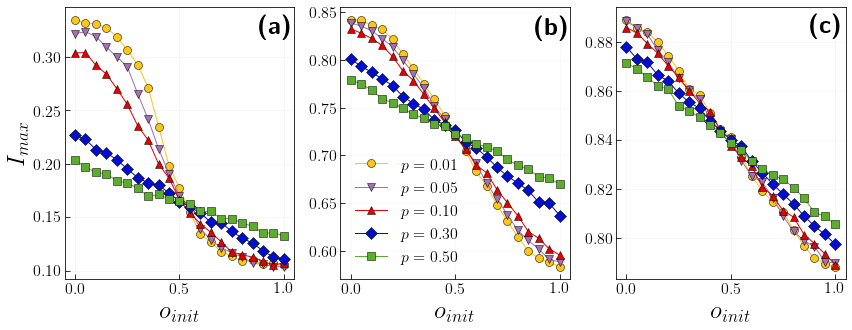

In [50]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas['0,01'])
plt.text(0.88, 0.322, r'\textbf{(a)}', fontsize=25)
# plt.ylim(0.09, 0.36)
# plt.vlines(0.5, 0, 0.4, linestyle='--', color='black', linewidth=2) # do we need to include it?
# plt.title(r'$\beta=0.01$')

plt.subplot(1, 3, 2)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas['0,10'], add_legend=True)
plt.text(0.88, 0.827, r'\textbf{(b)}', fontsize=25)
plt.ylabel('')
# plt.title(r'$\beta=0.10$')

plt.subplot(1, 3, 3)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas['0,50'])
plt.ylabel('')
plt.text(0.88, 0.884, r'\textbf{(c)}', fontsize=25)
# plt.title(r'$\beta=0.50$')

# plt.show()
# plt.savefig("../plots/paper/imax_vs_oinit.pdf")

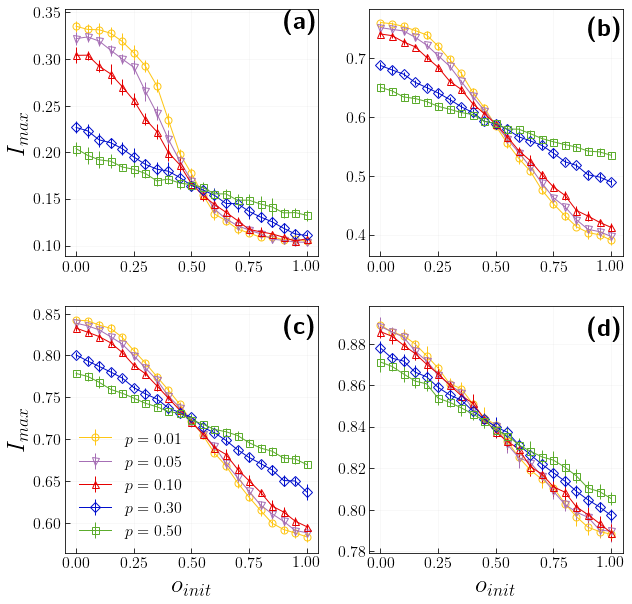

In [21]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas['0,01'])
plt.xlabel('')
plt.text(0.9, 0.333, r'\textbf{(a)}', fontsize=25)
# plt.ylim(0.09, 0.36)
# plt.vlines(0.5, 0, 0.4, linestyle='--', color='black', linewidth=2) # do we need to include it?
# plt.title(r'$\beta=0.01$')

plt.subplot(2, 2, 2)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas['0,05'])
plt.xlabel('')
plt.ylabel('')
plt.text(0.9, 0.74, r'\textbf{(b)}', fontsize=25)
# plt.title(r'$\beta=0.05$')

plt.subplot(2, 2, 3)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas['0,10'], add_legend=True)
plt.text(0.9, 0.827, r'\textbf{(c)}', fontsize=25)
# plt.title(r'$\beta=0.10$')

plt.subplot(2, 2, 4)
plot_max_infection_peak_vs_beta_per_posFrac(dfs_betas['0,50'])
plt.ylabel('')
plt.text(0.9, 0.884, r'\textbf{(d)}', fontsize=25)
# plt.title(r'$\beta=0.50$')

plt.show()

# TODO: run simulations with nruns=10 plot errors (?)

In [34]:
def plot_max_infection_peak_vs_beta_per_posFrac_grid(dfs, tmp_fPs, markers=markers, colors=colors,
                                                    fun=max_infection_rate, add_legend=False, max_xlim=50):
    i = 0
    markers_legend = []
    plt.figure(figsize=(12, 12))
    for fP in tmp_fPs:
        plt.subplot(3, 3, i + 1)
        j = 0
        for p, df in dfs.items():
            tmp = df[fPs.index(fP)]
            plt.plot(tmp.step, tmp.infectedRate, 'o--', label=f'p={p}', linewidth=1, 
                     color=colors[j], marker=markers[j], mfc='none', markersize=6)
            j += 1
        i += 1
        if i == 1 or i == 4 or i == 7:
            plt.ylabel(r'$I$')
        if i in [7, 8, 9]:
            plt.xlabel(r'$t$')
        
        plt.xlim(-1, max_xlim)
        plt.title('posFrac={}'.format(fP))
    if add_legend:
        plt.legend(fontsize=14)

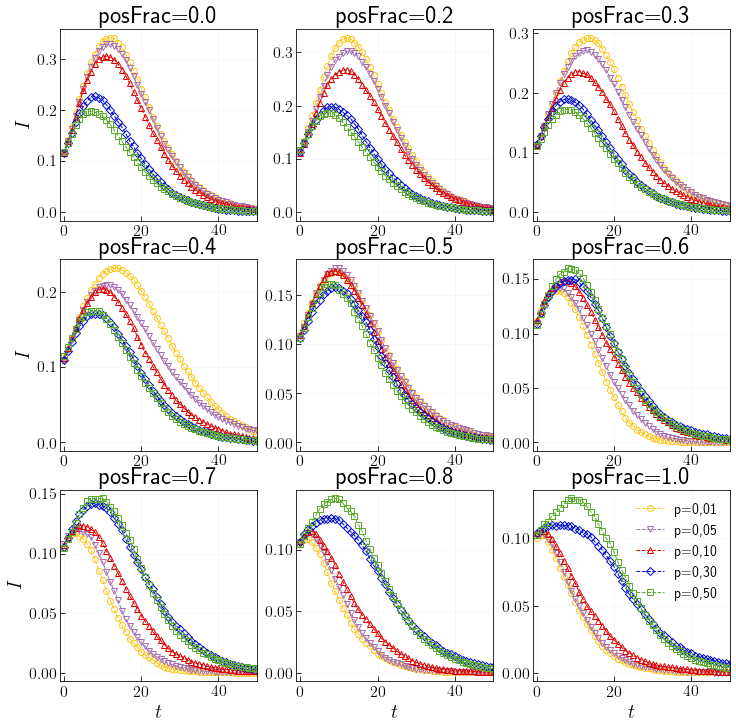

In [23]:
tmp_fPs = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]

plot_max_infection_peak_vs_beta_per_posFrac_grid(dfs_betas['0,01'], tmp_fPs, add_legend=True)

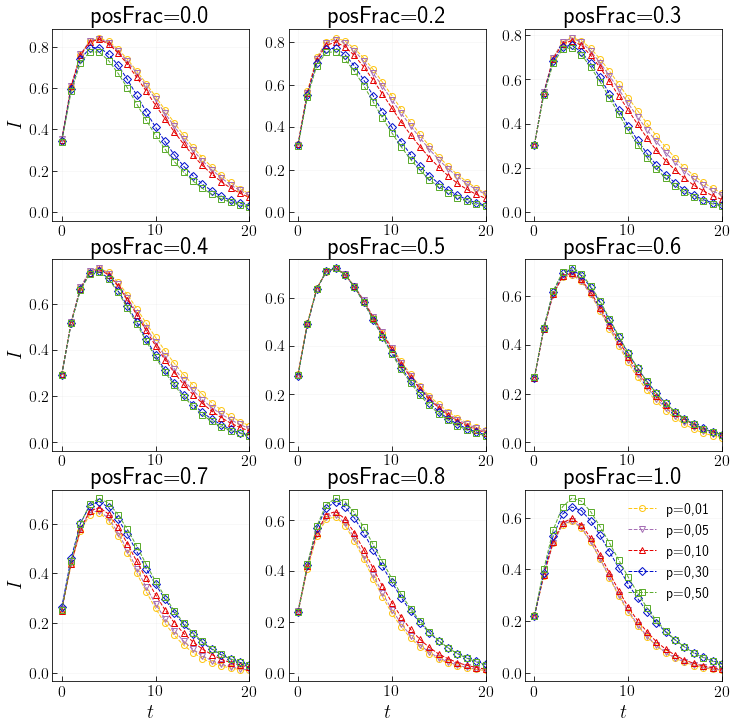

In [24]:
tmp_fPs = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]

plot_max_infection_peak_vs_beta_per_posFrac_grid(dfs_betas['0,10'], tmp_fPs, add_legend=True, max_xlim=20)